In [ ]:
import os
import gc
import json
import math
import cv2
import PIL
import re
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
#from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
%matplotlib inline
#from keras.preprocessing import image
import glob
import tensorflow.keras.applications.densenet as dense
import seaborn as sns

In [ ]:
import pandas as pd

train_file_path = '/content/train.csv.zip'
test_file_path = '/content/test.csv'

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

print('Training data shape: ', train_df.shape)
print(' ')
print('Test data shape: ', test_df.shape)
print(' ')

display(train_df.head(5))

display(test_df.head(5))

Training data shape:  (33126, 8)
 
Test data shape:  (10982, 5)
 


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [ ]:
import pandas as pd

# Assuming you have a CSV file named 'your_data.csv'
train = pd.read_csv('/content/train.csv.zip')

# Now you can use the 'train' DataFrame
train['benign_malignant'].value_counts(normalize=True)


benign       0.98237
malignant    0.01763
Name: benign_malignant, dtype: float64

In [ ]:
train['sex'].value_counts(normalize=True)

male      0.516621
female    0.483379
Name: sex, dtype: float64

In [ ]:
train['target'].groupby(train['sex']).mean()

sex
female    0.013766
male      0.021311
Name: target, dtype: float64

In [ ]:
train['target'].groupby(train['age_approx']).mean()

age_approx
0.0     0.000000
10.0    0.000000
15.0    0.015152
20.0    0.009160
25.0    0.010363
30.0    0.010178
35.0    0.008772
40.0    0.006711
45.0    0.012091
50.0    0.012412
55.0    0.016736
60.0    0.020062
65.0    0.027701
70.0    0.029472
75.0    0.063201
80.0    0.085919
85.0    0.060403
90.0    0.200000
Name: target, dtype: float64

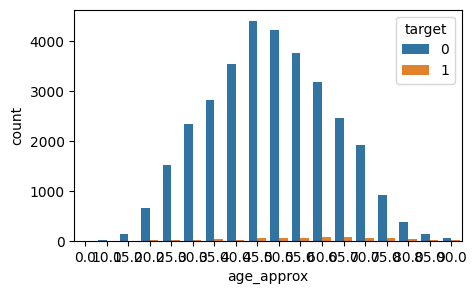

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
sns.countplot(x=train['age_approx'], hue=train['target'])
plt.show()


In [ ]:
train['anatom_site_general_challenge'].value_counts(normalize=True)

torso              0.516734
lower extremity    0.258198
upper extremity    0.152857
head/neck          0.056904
palms/soles        0.011503
oral/genital       0.003804
Name: anatom_site_general_challenge, dtype: float64

In [ ]:
train['target'].groupby(train['anatom_site_general_challenge']).mean()

anatom_site_general_challenge
head/neck          0.039892
lower extremity    0.014732
oral/genital       0.032258
palms/soles        0.013333
torso              0.015257
upper extremity    0.022276
Name: target, dtype: float64

In [ ]:
train_df = train[['sex','age_approx','anatom_site_general_challenge','diagnosis','target']]
train_df.head()

,sex,age_approx,anatom_site_general_challenge,diagnosis,target
0,male,45.0,head/neck,unknown,0
1,female,45.0,upper extremity,unknown,0
2,female,50.0,lower extremity,nevus,0
3,female,45.0,head/neck,unknown,0
4,female,55.0,upper extremity,unknown,0


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df = train_df.apply(lambda col: le.fit_transform(col.astype(str)), axis=0, result_type='expand')
train_df.head()


,sex,age_approx,anatom_site_general_challenge,diagnosis,target
0,1,8,0,8,0
1,0,8,6,8,0
2,0,9,1,5,0
3,0,8,0,8,0
4,0,10,6,8,0


In [ ]:
def check_melanoma_status(image_name):
    row = train_df[train_df['image_name'] == image_name]

    if not row.empty:
        melanoma_status = row.iloc[0]['target']

        if melanoma_status == 1:
            print(f"The image '{image_name}' is classified as melanoma.")
        else:
            print(f"The image '{image_name}' is not classified as melanoma.")
    else:
        print(f"Image '{image_name}' not found in the training data.")

# Example: Replace 'your_image_name.jpg' with the actual image name you want to check
image_to_check = 'ISIC_0075914'
check_melanoma_status(image_to_check)

The image 'ISIC_0075914' is not classified as melanoma.
